In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')
import dataPrep as dP

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   p       float64
 1   theta   float64
 2   beta    float64
 3   nphe    int64  
 4   ein     float64
 5   eout    float64
dtypes: float64(5), int64(1)
memory usage: 228.9 MB
None
(5000000,)
Index(['p', 'theta', 'beta', 'nphe', 'ein', 'eout'], dtype='object')


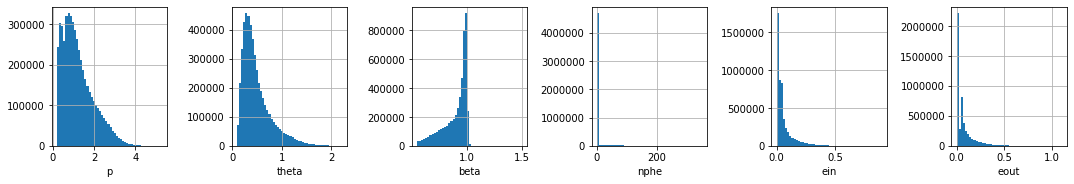

In [5]:
#Get the data and visualize the columns
data,targets = dP.getData()
print(data.info())
print(targets.shape)
columns = data.columns
print(columns)
nrows = 20; ncols = 20
plt.figure(1,figsize = (50,50))
i = 1
for col in columns:
    plt.subplot(nrows,ncols,i)
    data[col].hist(bins = 50)
    plt.xlabel(col)
    i += 1
plt.tight_layout()
plt.show() 

We need to transform the skewed features into more distributed ones and use the log transform for this and then normalize them

In [6]:
def logx(x):
    return np.log(1 + x) #Add a small offset to avoid log of zero

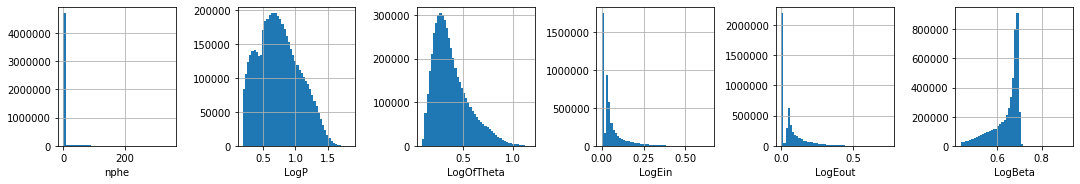

In [7]:
#Transform the features 
data['LogP'] = data['p'].apply(logx)
data['LogOfTheta'] = data['theta'].apply(logx)
data['LogEin'] = data['ein'].apply(logx)
data['LogEout'] = data['eout'].apply(logx)
data['LogBeta'] = data['beta'].apply(logx)
data.drop(columns = ['p','theta','ein','eout','beta'],inplace = True)
i = 1
nrows = 20; ncols = 20
plt.figure(1,figsize = (50,50))
for col in list(data.columns):
    plt.subplot(nrows,ncols,i)
    data[col].hist(bins = 50)
    plt.xlabel(col)
    i += 1
plt.tight_layout()
plt.show()

In [8]:
#Transform the labels 
from sklearn.preprocessing import LabelEncoder
targetEncoder = LabelEncoder()
labels = targetEncoder.fit_transform(targets)
print(labels[:10])
print(targetEncoder.inverse_transform([1,2,3,0]))

[1 1 3 1 3 1 3 3 3 3]
[ 211  321 2212  -11]


In [9]:
#Split the dataset
from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test = train_test_split(np.array(data),labels,test_size = 0.25,random_state = 42)
del data,labels
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3750000, 6)
(1250000, 6)
(3750000,)
(1250000,)


To compare the effects between data transformation and using the original data, we can train the 
same set of models with the same characteristcs. 

In [12]:
#Get a few models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=42, n_jobs=2)
knn = KNeighborsClassifier(n_jobs=2)
lreg = LogisticRegression(random_state=42)
lsvc = LinearSVC(random_state=42)
classifiersList = [dt,rfc,knn,lreg,lsvc]
classifiersScores = []
classifiersTrainTimes = []

In [ ]:
#Train the models 
def trainPredict(model,sampleSize,x_train,y_train,x_test,y_test):
    '''
    model: The algorithm
    sampleSize: The size of samples to draw from
    x_train: Training dataset
    y_train: Labels 
    x_test: Test set
    y_test: Test labels
    '''
    results = {}
    start = time()
    learner = model.fit(x_train[:sampleSize],y_train[:sampleSize])
    end = time()
    results['training_time'] = end - start
    
    #Predictions 
    start = time()
    predictions_test = learner.predict(x_test)
    end = time()
    results['testing_time'] = end - start
    results['acc_train'] = accuracy_score(y_train[:5000],learner.predict(x_train[:5000]))
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    print ("{} trained on {} samples.".format(model.__class__.__name__, sampleSize))
    results['clf_name'] = model.__class__.__name__
    return results 

#Create lists to store results
clf_ltrain_times = []
clf_lnames = []
clf_testAccuracies = []
clf_trainAccuracies = []

for model in classifiersList:
    clfResults = trainPredict(model,len(y_train),x_train,y_train,x_test,y_test)
    clf_ltrain_times.append(clfResults['training_time'])
    clf_testAccuracies.append(clfResults['acc_test'])
    clf_trainAccuracies.append(clfResults['acc_train'])
    clf_lnames.append(clfResults['clf_name'].replace('Classifier', ''))
print(clf_ltrain_times)
print("\n")
print(clf_testAccuracies)
print("\n")
print(clf_lnames)

DecisionTreeClassifier trained on 3750000 samples.


In [ ]:
#Plot the results 
plt.figure(1,figsize = (45,15))
nGroups = len(clf_testAccuracies)
index = np.arange(nGroups)
barWidth = 0.35
opacity = 0.4
data1 = clf_testAccuracies 
plt.subplot(2,3,1)
plt.xlabel('Classifier')
plt.ylabel('Test Accuracy')
plt.title('Classifier Testing Accuracies')
plt.xticks(index, clf_testAccuracies)
bar1 = plt.bar(index, data1, barWidth, alpha=opacity, color='g')
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%f' % height, ha='center', va='top',color = 'b')
plt.tight_layout()
plt.show()